
# Introduction
## File and Data Field Descriptions
From [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/data):
- **train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
    - `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - `Cabin` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where `side` can be either `P` for *Port* or `S` for *Starboard*.
    - `Destination` - The planet the passenger will be debarking to.
    - `Age` - The age of the passenger.
    - `VIP` - Whether the passenger has paid for special VIP service during the voyage.
    - `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - `Name` - The first and last names of the passenger.
    - `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of `Transported` for the passengers in this set.
- **sample_submission.csv** - A submission file in the correct format.
    - `PassengerId` - Id for each passenger in the test set.
    - `Transported` - The target. For each passenger, predict either `True` or `False`.


# Preamble
## Import Libraries

In [56]:
from pathlib import Path
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Settings

In [2]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

In [26]:
data_path = Path.cwd().joinpath("data")

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 1000)

rc = {
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.edgecolor": "none",
}
sns.set_theme(context="notebook", style="whitegrid", palette="pastel", rc=rc)

# Load Data

In [4]:
train = pd.read_csv(data_path.joinpath("train.csv"))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
test = pd.read_csv(data_path.joinpath("test.csv"))
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [8]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


# Data Validation

In [9]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [10]:
train[train.isna().any(axis="columns")].isna().sum(axis="columns").describe()

count    2087.00000
mean        1.11356
std         0.34207
min         1.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         3.00000
dtype: float64

# Feature Engineering
## Feature Extraction

In [11]:
train[["PassengerGroup", "PassengerNumber"]] = (
    train["PassengerId"].str.extract(r"^(?P<Group>\d{4})_(?P<Number>\d{2})").astype(int)
)
train[["PassengerGroup", "PassengerNumber"]].isna().sum()

PassengerGroup     0
PassengerNumber    0
dtype: int64

In [12]:
train[["FirstName", "LastName"]] = train["Name"].str.extract(
    r"^(?P<First>\w*)\s*(?P<Last>\w*)$"
)
np.sum(train[["FirstName", "LastName"]].isna().index != train[["Name"]].isna().index)

0

In [13]:
train[["CabinDeck", "CabinNumber", "CabinSide"]] = (
    train["Cabin"]
    .str.extract(r"^(?P<Deck>\w)\/(?P<Number>\w*)\/(?P<Side>\w)$")
    .replace({"P": "Port", "S": "Starboard"})
)
np.sum(
    train[["CabinDeck", "CabinNumber", "CabinSide"]].isna().index
    != train[["Cabin"]].isna().index
)

0

In [14]:
train = train.drop(["PassengerId", "Name", "Cabin"], axis="columns")

## Feature Construction

In [15]:
train = train.merge(
    train["PassengerGroup"].value_counts().rename("GroupSize"),
    how="outer",
    left_on="PassengerGroup",
    right_index=True,
)

# Exploratory Data Analysis

In [16]:
categorical_features = [
    "PassengerNumber",
    "GroupSize",
    "HomePlanet",
    "CryoSleep",
    "CabinDeck",
    "CabinSide",
    "Destination",
    "VIP",
]

numerical_features = [
    "PassengerGroup",
    "Age",
]

log_numerical_features = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
]

label = "Transported"

## Feature Relationships to Label

Text(0.5, 1.0, 'Transportation Count')

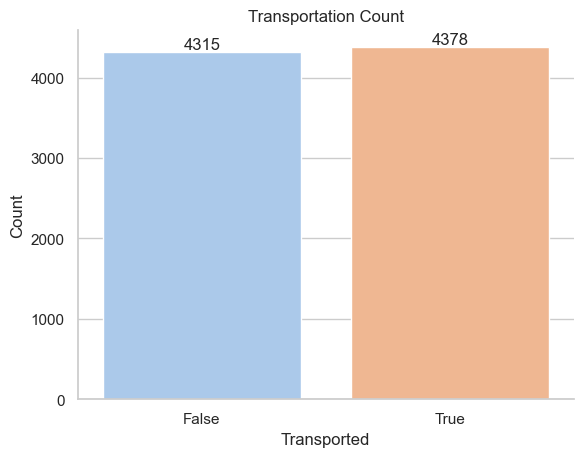

In [47]:
ax = sns.countplot(train, x="Transported")
for container in ax.containers:
    ax.bar_label(container, label_type="edge")
ax.set_ylabel("Count")
ax.set_title("Transportation Count")

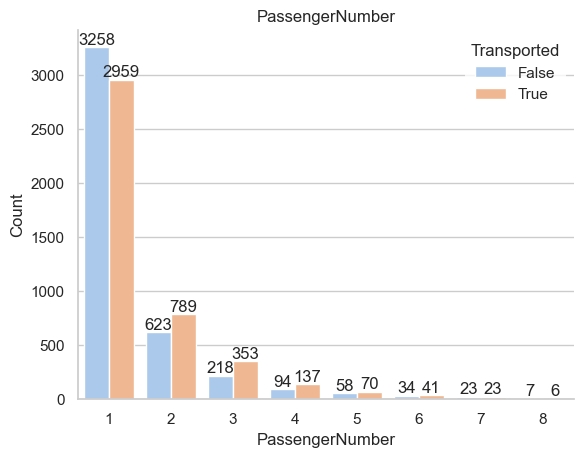

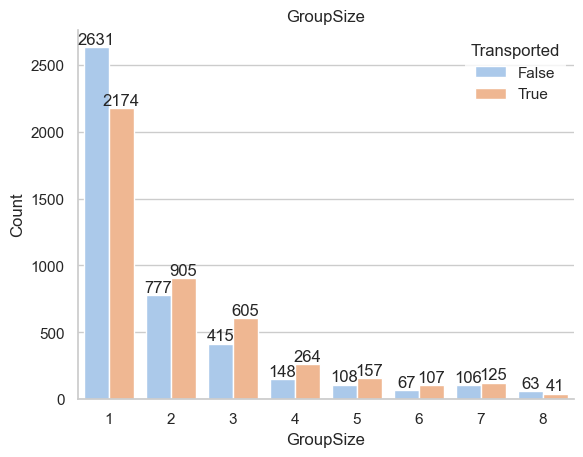

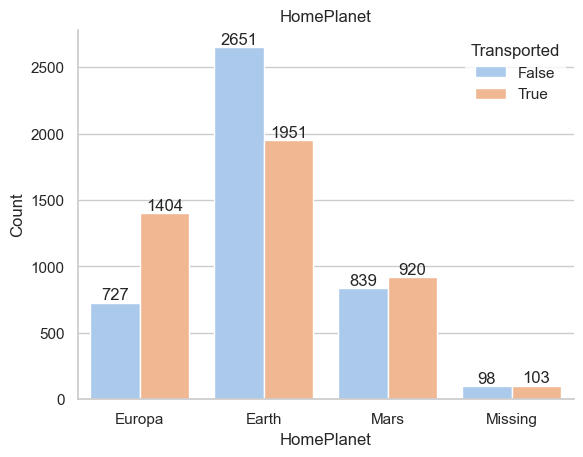

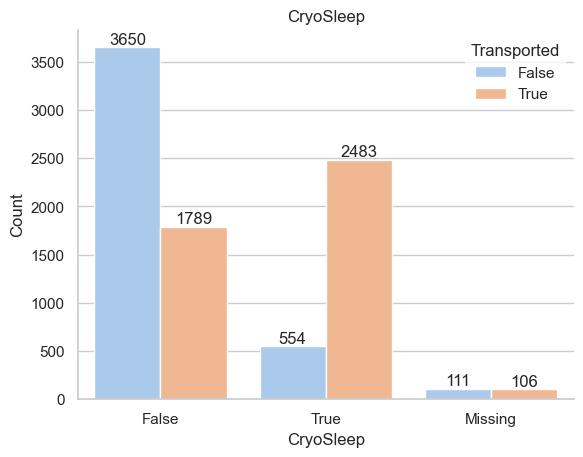

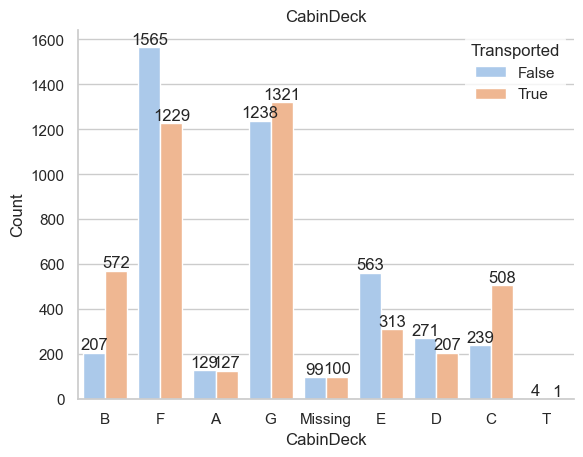

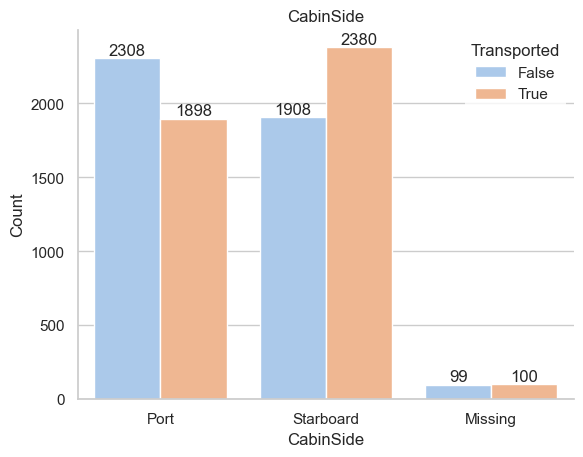

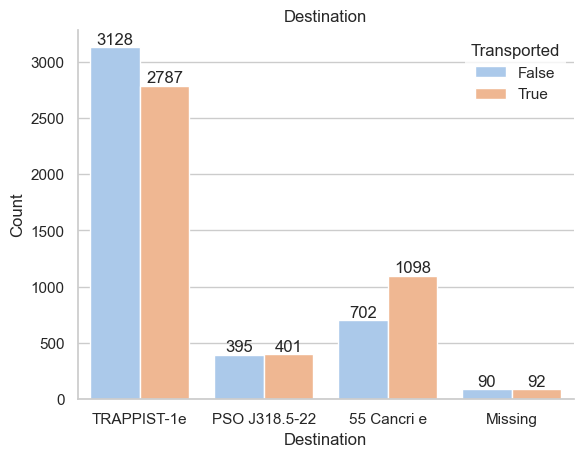

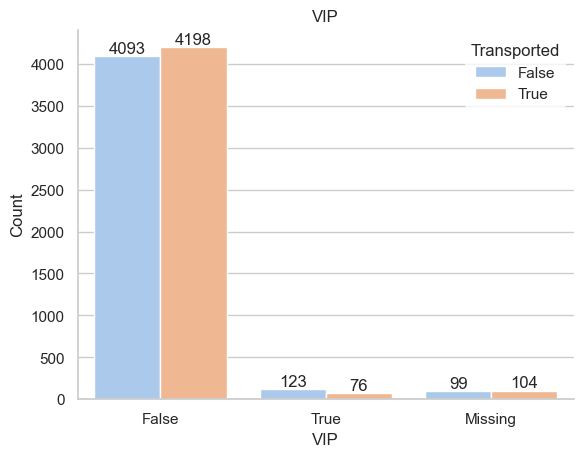

In [46]:
for feature in categorical_features:
    ax = sns.countplot(train.fillna("Missing"), x=feature, hue="Transported")
    for bar in ax.containers:
        ax.bar_label(bar, label_type="edge")
    ax.set_ylabel("Count")
    ax.set_title(feature)
    plt.show()

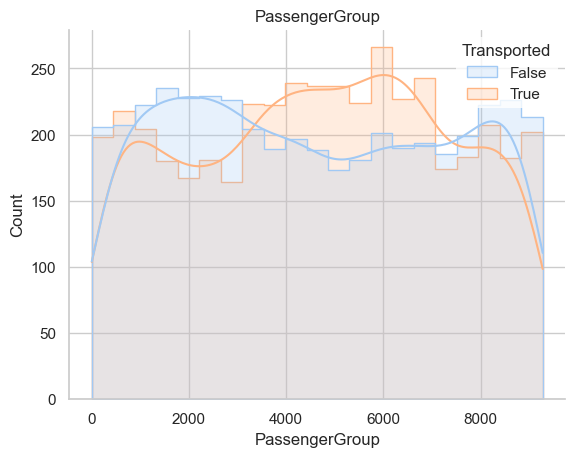

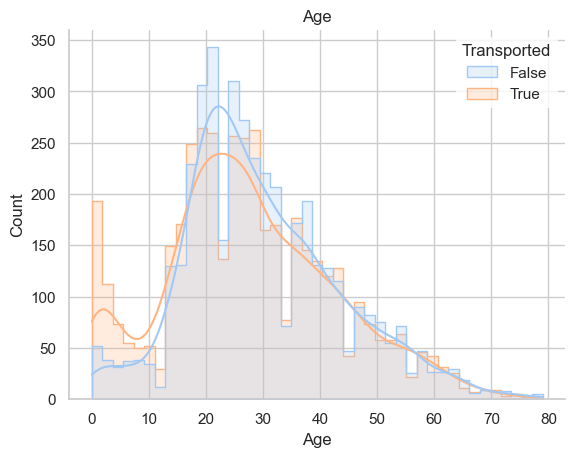

In [29]:
for feature in numerical_features:
    ax = sns.histplot(data=train, x=feature, hue=label, element="step", kde=True)
    ax.set_title(feature)
    plt.show()

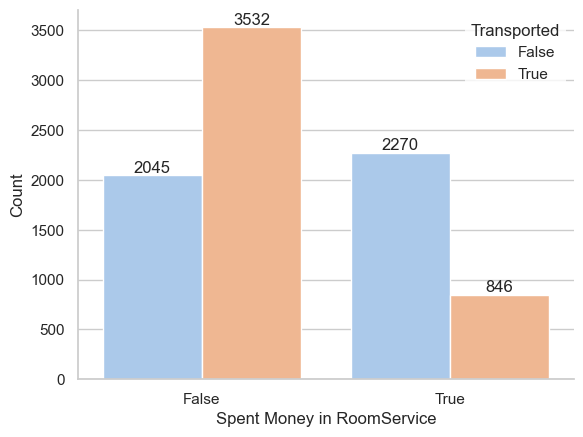

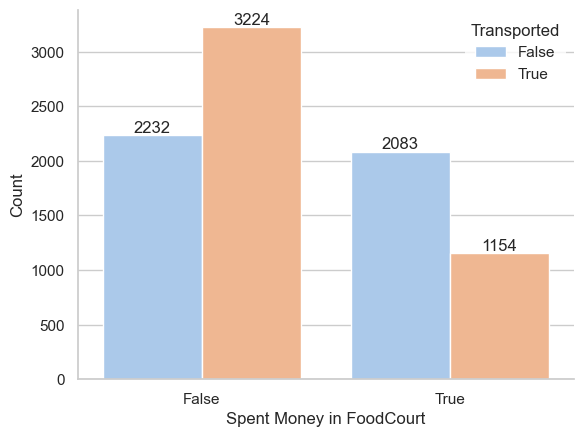

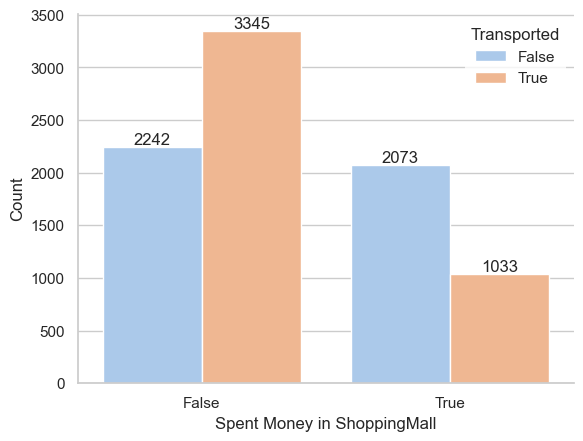

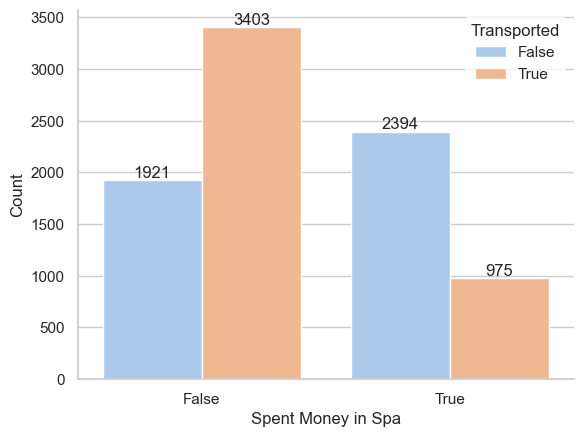

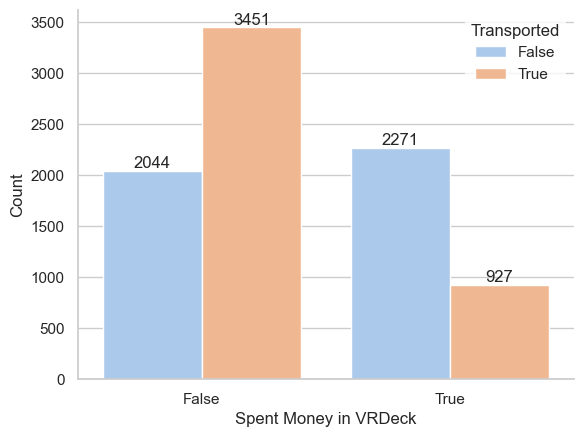

In [30]:
# Note: Missing values are being treated as 0
for feature in log_numerical_features:
    ax = sns.countplot(train[[feature, label]].astype(bool), x=feature, hue=label)
    for bar in ax.containers:
        ax.bar_label(bar, label_type="edge")
    ax.set_xlabel(f"Spent Money in {feature}")
    ax.set_ylabel("Count")
    plt.show()

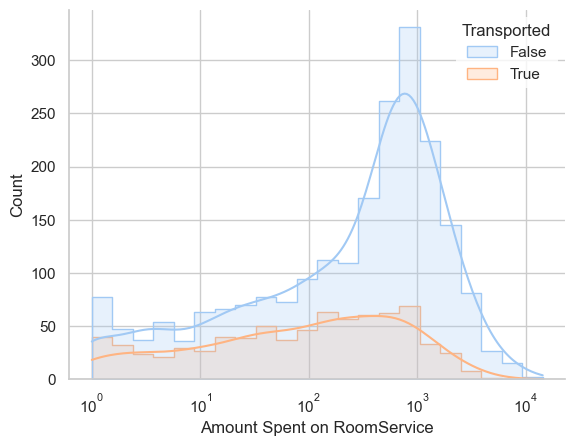

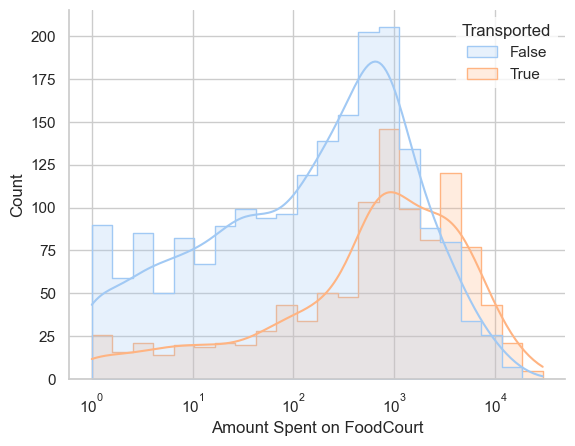

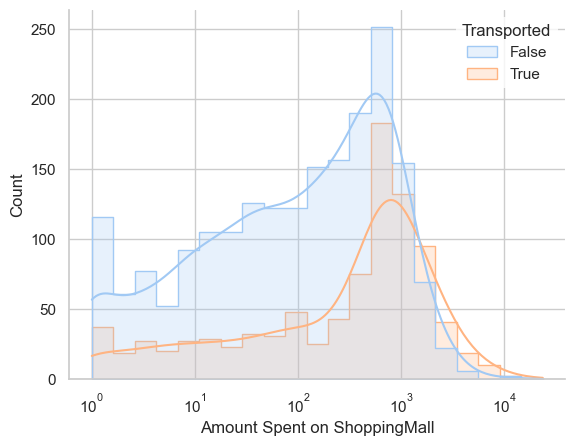

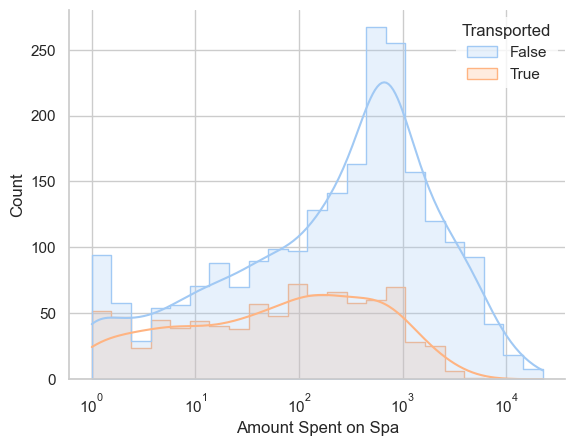

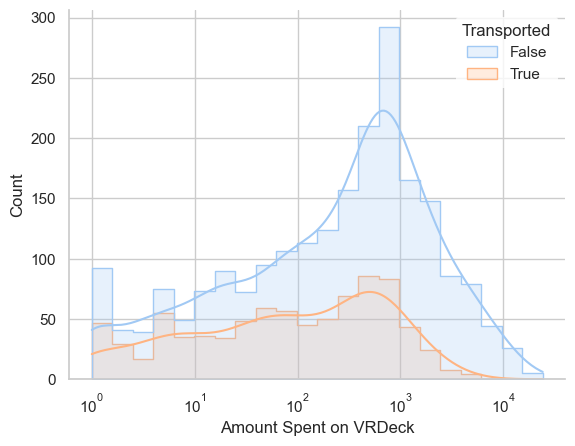

In [31]:
for feature in log_numerical_features:
    ax = sns.histplot(
        data=train[train[feature] > 0],
        x=feature,
        hue=label,
        element="step",
        kde=True,
        log_scale=True,
    )
    ax.set_xlabel(f"Amount Spent on {feature}")
    plt.show()

## Covariance

In [57]:
features = set(categorical_features + numerical_features + log_numerical_features)

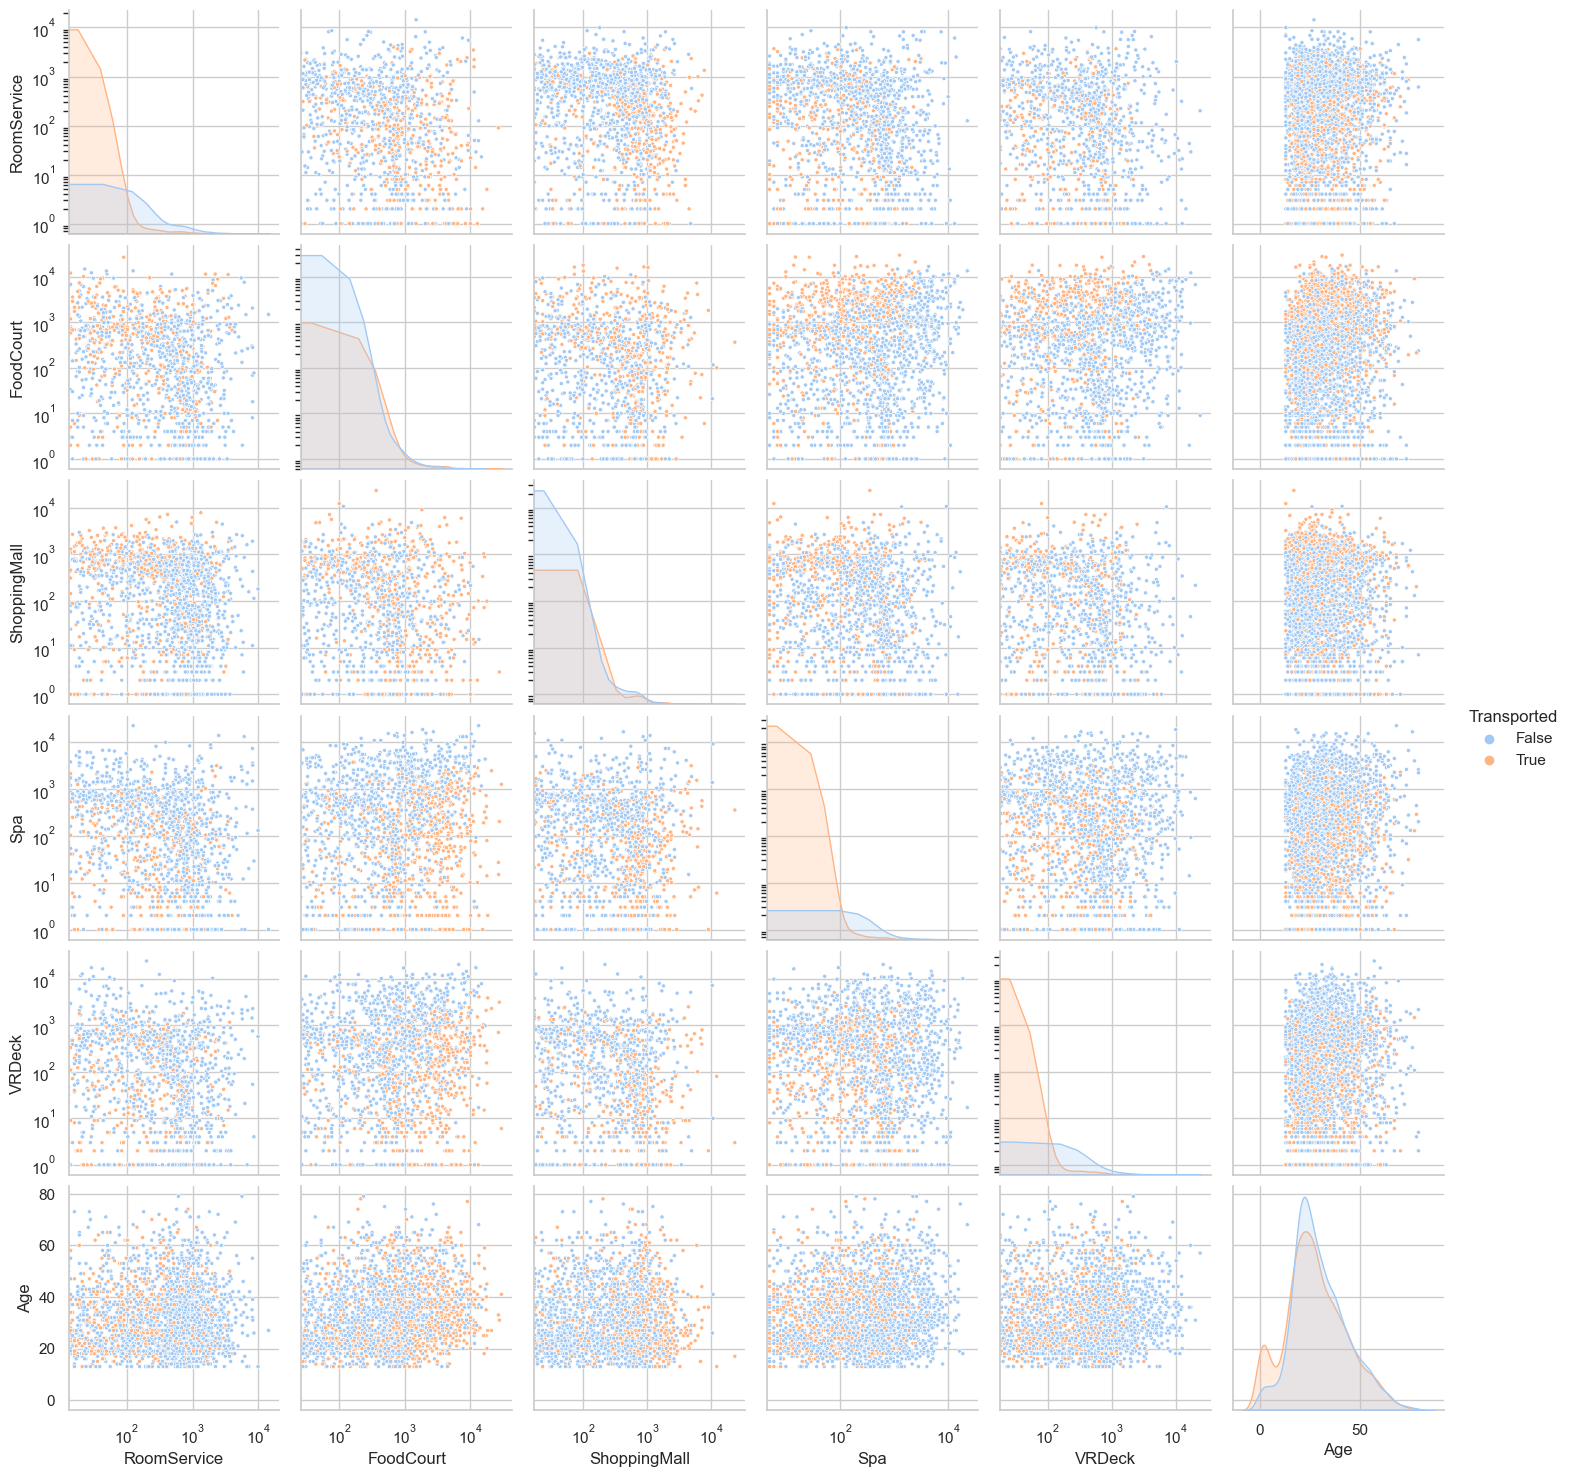

In [81]:
pp = sns.pairplot(train, vars=log_numerical_features + ["Age"], markers=".", hue=label)
for ax in pp.axes.flat:
    if ax.get_xlabel() in log_numerical_features:
        ax.set(xscale="log")
    if ax.get_ylabel() in log_numerical_features:
        ax.set(yscale="log")

In [84]:
for categorical_feature, numeric_feature in product(
    categorical_features, numerical_features + log_numerical_features
):
    ax = sns.violinplot(
        data=train, y=categorical_feature, x=numeric_feature, hue=label, split=True
    )
    if numeric_feature in log_numerical_features:
        ax.set(yscale="log")
    plt.show()